In [1]:
## configuration

In [2]:
# input file (set to None to guess):
input_file = '/Users/telmo/projects/ghostborders/berlin-media-borders.csv'

# countries:
# israel, belgium, belgium2, ukraine, poland, portugal, romania
country = 'berlin'

# borders type
# media, comment
data_source = 'media'
# two, many
partitions = 'many'

# resolutions:
# c (crude), l (low), i (intermediate), h (high), f (full)
resolution = 'i'

# picture width
width = 12.0

## visualization

In [3]:
# colors
land_color = 'white'
water_color = 'skyblue'
coastline_color = 'grey'
border_color = 'black'
phantom_border_color = 'red'

# widths
border_width = 2.
coastline_width = 3.
phantom_border_width_factor = 3.
river_width = 1.5
point_size_factor = 10.

# options
draw_photo_density = False
draw_population_density = False
draw_rivers = True

### constants

In [4]:
country_coords = {
    'israel': [29.340105, 33.736538, 33.446167, 36.098598],
    'belgium': [49.4, 2.420480, 51.726419, 6.589545],
    'belgium2': [48.5, 1.51, 53.0, 8.5],
    'poland': [48.54, 13.95, 55.20, 24.94],
    'portugal': [36.76, -9.93, 42.21, -5.64],
    'romania': [43.45, 20.10, 48.72, 30.62],
    'ukraine': [44.00, 21.00, 53.00, 42.00],
    'berlin': [52.31, 13.05, 52.69, 13.77]
}

country_NUTS_codes = {
    'israel': [],
    'belgium': ['BE'],
    'belgium2': ['BE', 'FR', 'NL', 'LU', 'DE'],
    'poland': ['PL'],
    'portugal': ['PT'],
    'romania': ['RO'],
    'ukraine': []
}

### read data

In [5]:
from numpy import genfromtxt
parts = ''
if partitions == 'two':
    parts = '2'
    
path = input_file
if input_file is None:
    path = '/Users/telmo/Dropbox/phantomgrenzen/countries/' + country + '/' + country + '-' + data_source + '-borders-crop' + parts + '.csv'
    
co = genfromtxt(path, delimiter=',', skip_header=1)
cols = co.shape[0]

dens = genfromtxt('/Users/telmo/Dropbox/phantomgrenzen/countries/'
                + country + '/' + country + '_photodensity.csv', delimiter=',', skip_header=1)

OSError: /Users/telmo/Dropbox/phantomgrenzen/countries/berlin/berlin_photodensity.csv not found.

### plot map

/Users/telmo/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


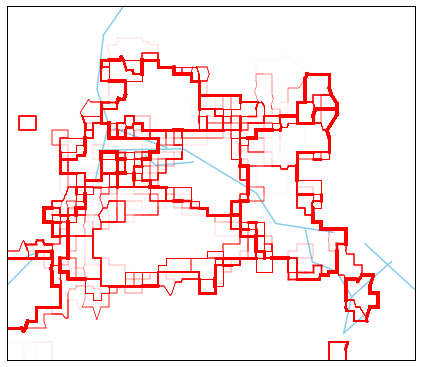

In [30]:
%matplotlib inline

#from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from mpl_toolkits.basemap import Basemap

cc = country_coords[country] 
x0 = cc[1]
y0 = cc[0]
x1 = cc[3]
y1 = cc[2]
dx = abs(x1 - x0)
dy = abs(y1 - y0)

height = width * dy / dx

plt.figure(figsize=(width, height))
m = Basemap(projection='merc', resolution=resolution, llcrnrlat=y0, llcrnrlon=x0, urcrnrlat=y1, urcrnrlon=x1)

xorig, yorig = m(x0, y0)

m.drawlsmask(resolution=resolution, grid=1.25, ocean_color=water_color, land_color=land_color)
m.drawcoastlines(linewidth=coastline_width, color=coastline_color)
if draw_rivers:
    m.drawrivers(color=water_color, linewidth=river_width)
m.fillcontinents(color=land_color, lake_color=water_color)

# draw population densities
if draw_population_density:
    s = m.readshapefile('/Users/telmo/projects/phantomborders/dens/dens', 'dens')

    min_dens = float("inf")
    max_dens = float("-inf")
    for info in m.dens_info:
        if info['NUTS_ID'][0:2] in country_NUTS_codes[country]:
            d = info['DENSITY']
            if d < 1:
                d = 1
            d = math.log(float(d))
            #d = float(d)
            if d < min_dens:
                min_dens = d
            if d > max_dens:
                max_dens = d

    norm = mpl.colors.Normalize(vmin=min_dens, vmax=max_dens)
    cmap = cm.Greens
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)

    for xy, info in zip(m.dens, m.dens_info):
        if info['NUTS_ID'][0:2] in country_NUTS_codes[country]:
            d = info['DENSITY']
            if d < 1:
                d = 1
            d = math.log(float(d))
            #d = float(d)
            poly = Polygon(xy, facecolor=sm.to_rgba(d), alpha=0.9)
            plt.gca().add_patch(poly)
else:
    m.drawcountries(linewidth=border_width)

# draw photo densities
if draw_photo_density:
    max_photo_dens = float("-inf")
    for i in range(len(dens)):
        pdens = math.log(dens[i][2])
        if pdens > max_photo_dens:
            max_photo_dens = pdens
    
    for i in range(len(dens)):
        x, y = m(dens[i][1], dens[i][0])
        x -= xorig
        y -= yorig
        weight = math.log(dens[i][2]) / max_photo_dens
        if weight < 0.001:
            weight = 0.001
        color = (0, 0, 1.0)
        weight *= point_size_factor
        #poly = m.ellipse(x, y, radius, radius, 20, facecolor=color, edgecolor='none', alpha=0.8)
        m.plot(x, y, 'b.', markersize=weight)

# draw phantom borders
for i in range(cols):
    x, y = m((co[i][1], co[i][3]), (co[i][0], co[i][2]))
    x = (x[0] - xorig, x[1] - xorig)
    y = (y[0] - yorig, y[1] - yorig)
    weight = co[i][4] * phantom_border_width_factor
    m.plot(x, y, phantom_border_color, linewidth=weight)
        
plt.show()